Test

In [170]:
import matplotlib.pyplot as plt
import pandas as pd
import pyvista as pv
import numpy as np
import openpyxl as py
import paho.mqtt.client as mqtt
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from dash import Dash, html, dcc
import plotly.express as px


In [171]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import minimum_spanning_tree

# Load dataset
file_path = 'Testdata.xlsx'  # Assuming this path holds the dataset
pipe_data = pd.read_excel(file_path)

# Functie om willekeurige coördinaten voor de eerste 50 pijpen te genereren (dit is een placeholder)
def generate_western_coordinates(n):
    latitudes = np.random.uniform(51.5, 52.8, n)  # Voorbeeld latitudes tussen 51.5 en 53.5
    longitudes = np.random.uniform(4.0, 5.5, n)   # Voorbeeld longitudes tussen 3.0 en 7.0
    return latitudes, longitudes

# Stel dat pipe_data al geladen is en de coördinaten van de eerste 50 pijpen zijn aangepast:
latitudes, longitudes = generate_western_coordinates(50)
pipe_data = pd.DataFrame({
    'SegmentID': [f'Segment {i+1}' for i in range(200)],  # 200 pijpen in totaal
    'QualityCheckStatus': np.random.choice(['Pass', 'Fail'], size=200),  # Random kwaliteit status
    'SegmentID': [f'NL{str(i).zfill(3)}' for i in range(51, 51 + new_rows_count)],
    'Location': np.random.choice(['The Hague', 'Amsterdam', 'Rotterdam', 'Haarlem', 'Leiden'], new_rows_count),
    'Material': np.random.choice(pipe_data['Material'], new_rows_count),
    'Diameter (mm)': np.random.choice(pipe_data['Diameter (mm)'], new_rows_count),
    'Length (m)': np.random.choice(pipe_data['Length (m)'], new_rows_count),
    'InstallationDate': pd.to_datetime(
        np.random.choice(pipe_data['InstallationDate'], new_rows_count)
    ),
    'LastRepairDate': pd.to_datetime(
        np.random.choice(pipe_data['LastRepairDate'], new_rows_count)
    ),
    'PH_Value': np.random.uniform(pipe_data['PH_Value'].min(), pipe_data['PH_Value'].max(), new_rows_count),
    'MaterialDensity (kg/m³)': np.random.choice(pipe_data['MaterialDensity (kg/m³)'], new_rows_count),
    'FlowRate (L/min)': np.random.choice(pipe_data['FlowRate (L/min)'], new_rows_count),
    'Pressure (PSI)': np.random.choice(pipe_data['Pressure (PSI)'], new_rows_count),
    'CorrosionLevel (%)': np.random.uniform(
        pipe_data['CorrosionLevel (%)'].min(), pipe_data['CorrosionLevel (%)'].max(), new_rows_count
    ),
    'CorrosionRate (mm/year)': np.random.uniform(
        pipe_data['CorrosionRate (mm/year)'].min(), pipe_data['CorrosionRate (mm/year)'].max(), new_rows_count
    ),
    'ChalkLevel (%)': np.random.choice(pipe_data['ChalkLevel (%)'], new_rows_count),
    'WaterTemperature (°C)': np.random.choice(pipe_data['WaterTemperature (°C)'], new_rows_count),
    'SedimentLevel (%)': np.random.choice(pipe_data['SedimentLevel (%)'], new_rows_count),
    'QualityCheckStatus': np.random.choice(pipe_data['QualityCheckStatus'], new_rows_count),
    'RepairPriority': np.random.choice(pipe_data['RepairPriority'], new_rows_count),
    'Latitude': generate_western_coordinates(new_rows_count)[0],
    'Longitude': generate_western_coordinates(new_rows_count)[1],
})
pipe_data.loc[:49, 'Latitude'] = latitudes
pipe_data.loc[:49, 'Longitude'] = longitudes

# Bereken de afstanden tussen alle pijpen (gebruik de Euclidische afstand)
coordinates = pipe_data[['Latitude', 'Longitude']].values
distances = cdist(coordinates, coordinates, metric='euclidean')

# Initialiseer een lijst voor de connecties per pijp
pipe_data['ConnectedTo'] = [[] for _ in range(len(pipe_data))]

# Gebruik minimum spanning tree (MST) om een enkele verbonden component te krijgen
# De minimum spanning tree geeft de verbindingen tussen de pijpen die het meest efficiënt zijn
mst = minimum_spanning_tree(distances)

# Verkrijg de rijen en kolommen van de niet-zero waarden van de MST matrix (verbindingen)
mst_rows, mst_cols = mst.nonzero()

# Verbind de pijpen op basis van de MST
for i, j in zip(mst_rows, mst_cols):
    if i != j:  # Vermijd verbindingen met zichzelf
        pipe_data.at[i, 'ConnectedTo'].append(pipe_data.at[j, 'SegmentID'])
        pipe_data.at[j, 'ConnectedTo'].append(pipe_data.at[i, 'SegmentID'])

# Controleer de eerste paar rijen om de wijzigingen te bekijken
print(pipe_data.head())
print(pipe_data[['SegmentID', 'ConnectedTo']].head())


  SegmentID QualityCheckStatus   Location  Material  Diameter (mm)  \
0     NL051               Fail  The Hague  Concrete            300   
1     NL052               Pass     Leiden  Concrete            100   
2     NL053               Pass     Leiden     Steel            200   
3     NL054               Fail  The Hague      HDPE            400   
4     NL055               Fail  Rotterdam     Steel            300   

   Length (m) InstallationDate LastRepairDate  PH_Value  \
0        2382       2006-11-30     2022-05-10  8.045202   
1        2297       1997-10-23     2023-07-21  7.422019   
2        1234       1993-12-18     2023-09-27  7.224831   
3        1028       1990-05-17     2022-06-27  7.263046   
4        1028       2006-08-11     2020-04-01  6.396772   

   MaterialDensity (kg/m³)  ...  Pressure (PSI)  CorrosionLevel (%)  \
0                      950  ...              80           15.568598   
1                     7200  ...              93           29.082894   
2          

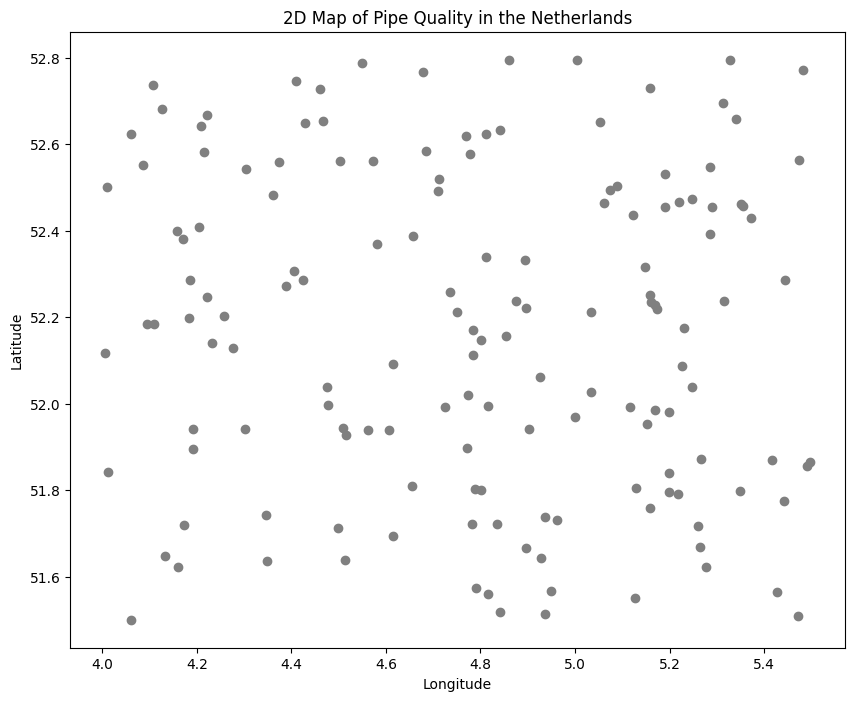

In [172]:
# 2D Map of Pipe Locations
def draw_pipe_map():
    fig, ax = plt.subplots(figsize=(10, 8))
    quality_colors = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'blue'}

    for i, row in pipe_data.iterrows():
        plt.scatter(row['Longitude'], row['Latitude'], color=quality_colors.get(row['QualityCheckStatus'], 'gray'), label=f"QualityCheckStatus {row['QualityCheckStatus']}")

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('2D Map of Pipe Quality in the Netherlands')
    plt.show()

draw_pipe_map()

/Users/Tom/Documents/GitHub/M3DMiB/venv/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning:

Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.



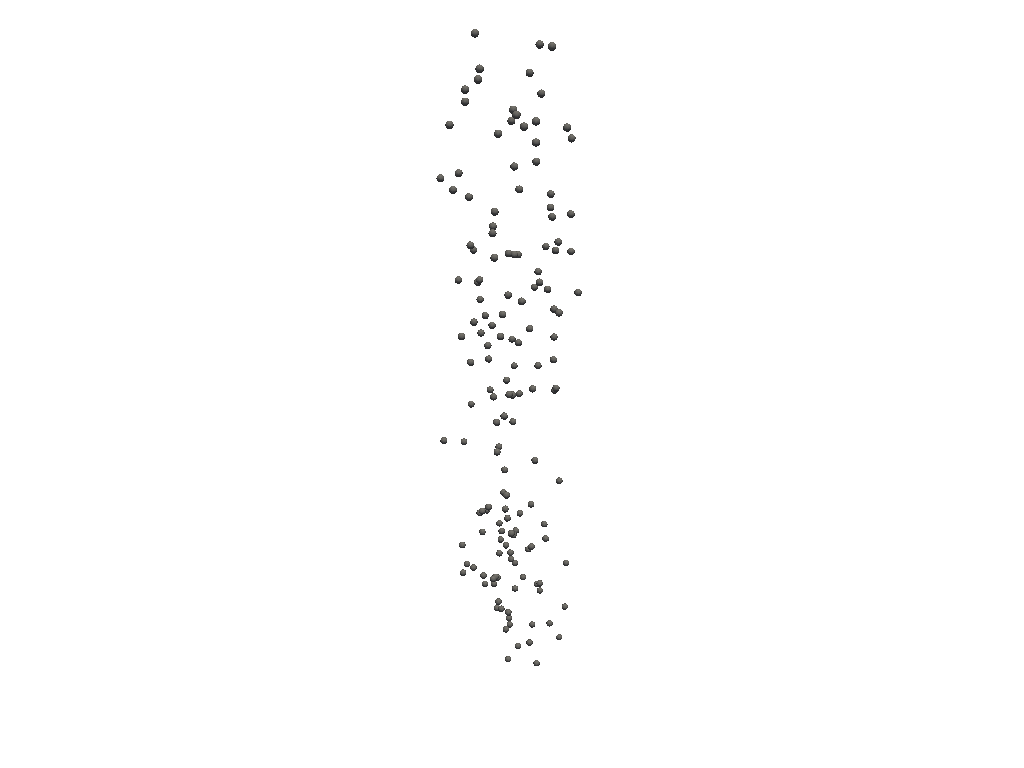

In [173]:
# Random z-coordinates to simulate depth or elevation
pipe_data['z'] = np.random.uniform(0, 10, size=len(pipe_data))

# 3D Model of Pipes
def draw_3d_pipes():
    plotter = pv.Plotter()
    quality_colors = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'blue'}
    
    for i, row in pipe_data.iterrows():
        point = pv.Sphere(radius=0.05, center=(row['Longitude'], row['Latitude'], row['z']))
        plotter.add_mesh(point, color=quality_colors.get(row['QualityCheckStatus'], 'gray'))

    plotter.show()

draw_3d_pipes()

In [174]:

# Simulated message handler
def on_message(client, userdata, msg):
    data = json.loads(msg.payload.decode())
    print(f"Pipe ID: {data['pipe_id']}, Pressure: {data['pressure']}, Flow Rate: {data['flow_rate']}")

client = mqtt.Client()
client.on_message = on_message
client.connect("test.mosquitto.org", 1883, 60)
client.subscribe("test/topic")
client.loop_start()

/var/folders/c1/7hq1ct91269cpqzjpgl886cm0000gn/T/ipykernel_4268/4056789534.py:6: DeprecationWarning:

Callback API version 1 is deprecated, update to latest version



<MQTTErrorCode.MQTT_ERR_SUCCESS: 0>

Exception in thread paho-mqtt-client-:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/Tom/Documents/GitHub/M3DMiB/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/Tom/Documents/GitHub/M3DMiB/venv/lib/python3.8/site-packages/paho/mqtt/client.py", line 4523, in _thread_main
    self.loop_forever(retry_first_connection=True)
  File "/Users/Tom/Documents/GitHub/M3DMiB/venv/lib/python3.8/site-packages/paho/mqtt/client.py", line 2297, in loop_forever
    rc = self._loop(timeout)
  File "/Users/Tom/Documents/GitHub/M3DMiB/venv/lib/python3.8/site-packages/paho/mqtt

In [175]:


# Create hypothetical dataset for training
pipe_data['maintenance_required'] = np.random.randint(0, 2, size=len(pipe_data))
X = pipe_data[['SedimentLevel (%)', 'Diameter (mm)', 'Length (m)']]
y = pipe_data['maintenance_required']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)


In [178]:
from dash import Dash, html, dcc
from dash.dependencies import Output, Input  # Deze importeren we voor de callback
import plotly.graph_objects as go
import pandas as pd

# Functie om lijnen tussen de pijpen te tekenen, aangepast om de kleur te bepalen
def create_pipe_connections(pipe_data):
    lines = []
    
    # Loop door elke pijp
    for i, row in pipe_data.iterrows():
        # Verkrijg de connecties voor elk segment (deze zijn nu lijsten, geen strings)
        connections = row['ConnectedTo']
        
        for connection in connections:
            # Zoek de coördinaten van het verbonden segment
            connected_row = pipe_data[pipe_data['SegmentID'] == connection]
            if not connected_row.empty:
                lat1, lon1 = row['Latitude'], row['Longitude']
                lat2, lon2 = connected_row['Latitude'].values[0], connected_row['Longitude'].values[0]
                
                # Kleur van de verbinding bepalen
                # Als de huidige pijp of de verbonden pijp een "Fail" heeft, wordt de verbinding rood
                if row['QualityCheckStatus'] == 'Fail' or connected_row['QualityCheckStatus'].values[0] == 'Fail':
                    color = 'red'
                else:
                    color = 'green'
                
                lines.append({'lat': [lat1, lat2], 'lon': [lon1, lon2], 'color': color})
    return lines

# Maak een map van 'Pass'/'Fail' naar kleurcodes voor de pijpen zelf
status_to_color = {
    'Pass': 'green',
    'Fail': 'red'
}

pipe_data['Color'] = pipe_data['QualityCheckStatus'].map(status_to_color)

# Creëer de lijnen voor de connecties met de juiste kleuren
pipe_lines = create_pipe_connections(pipe_data)

# Plotly map voor Dash visualisatie met lijnen tussen pijpen
fig = go.Figure()

# Voeg de pijplocaties toe
fig.add_trace(go.Scattermapbox(
    lat=pipe_data['Latitude'],
    lon=pipe_data['Longitude'],
    mode='markers',
    marker=dict(size=9, color=pipe_data['Color'], showscale=False),  # Kleur op basis van status
    text=pipe_data['SegmentID'],
    name='Pipes',
    legendgroup='Pipes',  # Verwijderd voor geen legendagroep
))

# Voeg de lijnen tussen verbonden pijpen toe, kleur afhankelijk van de pijpstatus
for line in pipe_lines:
    fig.add_trace(go.Scattermapbox(
        lat=line['lat'],
        lon=line['lon'],
        mode='lines',
        line=dict(width=2, color=line['color']),
        name='Pipe Connections',
        legendgroup='Pipes',  # Groeperen voor de legend
        showlegend=False  # Zorg ervoor dat de lijnen niet als aparte items in de legende verschijnen
    ))

# Voeg een aparte trace toe voor de legend, zodat alleen 'Pass' en 'Fail' zichtbaar zijn
fig.add_trace(go.Scattermapbox(
    lat=[None],  # Geen zichtbare punten
    lon=[None],  # Geen zichtbare punten
    mode='markers',
    marker=dict(color='green', size=10),
    name='Pass',
    legendgroup='Pass',  # Groeperen voor de legend
))

fig.add_trace(go.Scattermapbox(
    lat=[None],  # Geen zichtbare punten
    lon=[None],  # Geen zichtbare punten
    mode='markers',
    marker=dict(color='red', size=10),
    name='Fail',
    legendgroup='Fail',  # Groeperen voor de legend
))

# Kaartinstellingen
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=10,
    mapbox_center={"lat": 52.0, "lon": 4.5},  # Pas het middelpunt van de kaart aan
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
    legend=dict(
        title="Pijpstatus",
        itemsizing='constant',
        tracegroupgap=0,
        itemclick="toggleothers",  # Hiermee kun je items in de legenda in- of uitschakelen
    ),
    hovermode='closest',
    clickmode='event+select'  # Zorgt voor interactiviteit bij klikken
)

# Functie voor het aanpassen van de transparantie
def update_transparency(fig, visibility):
    for trace in fig['data']:
        if 'Pipes' in trace['legendgroup']:
            if trace['marker']['color'] == 'green' and visibility == 'Fail':
                trace['marker']['opacity'] = 0.6  # Maak groen doorzichtiger
            elif trace['marker']['color'] == 'red' and visibility == 'Pass':
                trace['marker']['opacity'] = 0.6  # Maak rood doorzichtiger
            else:
                trace['marker']['opacity'] = 1.0  # Zorg ervoor dat de geselecteerde kleur volledig zichtbaar blijft
    return fig

# Dash App voor de webpagina
app = Dash(__name__)

app.layout = html.Div(children=[
    html.H1(children='Pipe Quality Digital Twin - Netherlands'),
    dcc.Graph(
        id='pipe-map',
        figure=fig,
        config={'displayModeBar': True}  # Verberg de toolbar voor eenvoud
    )
])

@app.callback(
    Output('pipe-map', 'figure'),
    Input('pipe-map', 'relayoutData')  # Reactie op klik in de legenda
)
def update_on_legend_click(relayoutData):
    if relayoutData and 'legendclick' in relayoutData:
        # Verkrijg de geselecteerde legendagroep
        selected_legend = relayoutData['legendclick']
        visibility = selected_legend[0]  # Krijg de geselecteerde status (Pass of Fail)
        fig = update_transparency(fig, visibility)  # Update de transparantie
        return fig
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


---------------------------------------------------------------------------
UnboundLocalError                         Traceback (most recent call last)
Cell In[178], line 139, in update_on_legend_click(relayoutData=None)
    137     fig = update_transparency(fig, visibility)  # Update de transparantie
    138     return fig
--> 139 return fig
        fig = Figure({
    'data': [{'lat': array([51.63531784, 52.42934131, 51.64760404, 52.03854473, 52.63300155,
                            52.19696475, 51.93780709, 51.80020389, 52.20204262, 51.94217639,
                            52.74660566, 51.5175791 , 52.728827  , 51.77470811, 52.24648377,
                            51.84283044, 52.56275631, 52.40879042, 51.80464813, 52.23439353,
                            52.68117556, 51.79123639, 52.55798508, 52.53086332, 51.99770534,
                            51.54984856, 51.71700724, 52.11625899, 52.111793  , 51.63752241,
                            51.87286189, 51.99120398, 52.56167629, 52.6678